In [1]:
from typing import *
from tqdm import tqdm
from selectolax.parser import HTMLParser
from datetime import timedelta, datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import pytz
import os
import seaborn as sns
import matplotlib.patches as mpatches

<h4>Derivatives and Volatility project</h4>

Team: 
<ul>
    <li>Mikhail Mironov</li>
    <li>Alena Tsvetkova</li>
</ul>

In this project we suggest an intrument allowing to buy and sell call options for a basket of publically traded mining companies. As there is currently no options on traditional markets for bitcoin, we believe that using these companies will be a good proxy for price dynamics of Bitcoin, therefore we can create derivatives based on these companies which are essentially derivatives on the price of Bitcoin.

<a href="https://www.nasdaq.com/articles/7-crypto-mining-stocks-that-could-make-you-a-fortune-if-you-dare">Crypto mining firms</a>
</br>
<a href="https://data.hashrateindex.com/stocks?tab=overview">Hashrate index</a>

<h4>Downloading list of stocks from Hashrate index</h4>

In [2]:
resp = requests.get(
    "https://data.hashrateindex.com/stocks?tab=overview"
)

dom = HTMLParser(resp.text)

In [3]:
table = dom.css_first('table[role="table"] tbody')

ticker_data = []

for row in table.css('tr[role="row"]')[1:]:
    name: str = row.css_first('td[role="cell"]:nth-child(1)').text()
    mcap: str = row.css_first('td[role="cell"]:nth-child(2)').text()

    ticker, company_name = name.split(" ", maxsplit=1)
    mcap, currency = mcap.split(" ")

    ticker_data.append({
        "ticker": ticker, "company_name": company_name,
        "mcap": mcap, "currency": currency
    })


df: pd.DataFrame = pd.DataFrame.from_dict(ticker_data)
df.head()

,ticker,company_name,mcap,currency
0,ANY,Sphere 3D Corp,16M,USD
1,DGHI,Digihost Technology Inc,39M,CAD
2,CORZQ,"Core Scientific, Inc.",220M,USD
3,CLSK,CleanSpark Inc,"3,780M",USD
4,WULF,TeraWulf Inc.,674M,USD


In [4]:
# filter out companies outside of US
df = df[df["currency"] == "USD"].copy()
# convert to integer millions
df["mcap"] = df["mcap"].str[:-1].replace(",", "", regex=True).astype(int)
df = df.sort_values(by="mcap", ascending=False)

<h4>Preprocessing daily klines data from Investing.com</h4>

In [5]:
tickers: List[str] = df["ticker"].tolist()[:10]
tickers

['MARA', 'CLSK', 'RIOT', 'CIFR', 'HUT', 'IREN', 'WULF', 'BTDR', 'CAN', 'BTBT']

In [6]:
def convert_volume(val: str) -> float:
    if isinstance(val, float):
        return np.nan
    if val.endswith("M"):
        return float(val[:-1]) * 1e6
    if val.endswith("K"):
        return float(val[:-1]) * 1e3
    if val.endswith("B"):
        return float(val[:-1]) * 1e9

In [7]:
# load data from the local directory. I manually downloaded data for these tickers from investing.com
# Yahoo finance data has too many non-trading days

df_tickers: pd.DataFrame = pd.DataFrame()

for file in os.listdir("data"):
    ticker: str = file.split(".")[0]

    df_file: pd.DataFrame = pd.read_csv(os.path.join("data", file))
    df_file["Date"] = pd.to_datetime(df_file["Date"])
    
    df_file.index = df_file["Date"]
    df_file = df_file[["Price", "Vol."]].copy()
    df_file.columns = ["close", "volume"]

    df_file["volume"] = df_file["volume"].apply(convert_volume)


    df_file = df_file.add_prefix(f"{ticker}_")

    df_tickers = pd.concat([df_tickers, df_file], axis=1)

<h4>Download BTC daily klines from Binance datavision</h4>

In [8]:
COLS_NAMES: List[str] = [
    "open_time", "open", "high", "low", 
    "close", "volume", "close_time", "quote", "num_trades", "taker_buy_base_vol", "taker_buy_quote_vol", "_"
]

In [9]:
from requests.models import Response


start: pd.Timestamp = df_tickers.index[0]
end: pd.Timestamp = df_tickers.index[-1]


def parse_response(resp: Response) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(resp.json(), columns=COLS_NAMES)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    return df


def get_btc_data(start: pd.Timestamp, end: pd.Timestamp, interval: str) -> pd.DataFrame:
    """download daily klines for BTCUSDT from Binance"""
    tmp_start = start

    params = {
        "symbol": "BTCUSDT",
        "interval": interval,
        "limit": 1000
    }

    df_btc: pd.DataFrame = pd.DataFrame()

    while tmp_start < end:
        params["startTime"] = f"{int(tmp_start.timestamp())}000"
        
        resp: Response = requests.get("https://api.binance.com/api/v3/klines", params=params)

        df: pd.DataFrame = parse_response(resp=resp)
        last_day: pd.Timestamp = df["open_time"].iloc[-1].floor("1d")

        tmp_start = last_day + timedelta(days=1) # start from next day
        df_btc = pd.concat([df_btc, df])
    
    num_cols: List[str] = list(set(df_btc.columns) - set(["open_time", "close_time"]))
    
    for col in num_cols:
        df_btc[col] = pd.to_numeric(df_btc[col])

    return df_btc

In [10]:
df_btc: pd.DataFrame = get_btc_data(start=start, end=end, interval="1d")
df_btc.head(1)

,open_time,open,high,low,close,volume,close_time,quote,num_trades,taker_buy_base_vol,taker_buy_quote_vol,_
0,2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,2019-01-02 23:59:59.999,1.338766e+08,218538,17921.600114,6.827790e+07,0


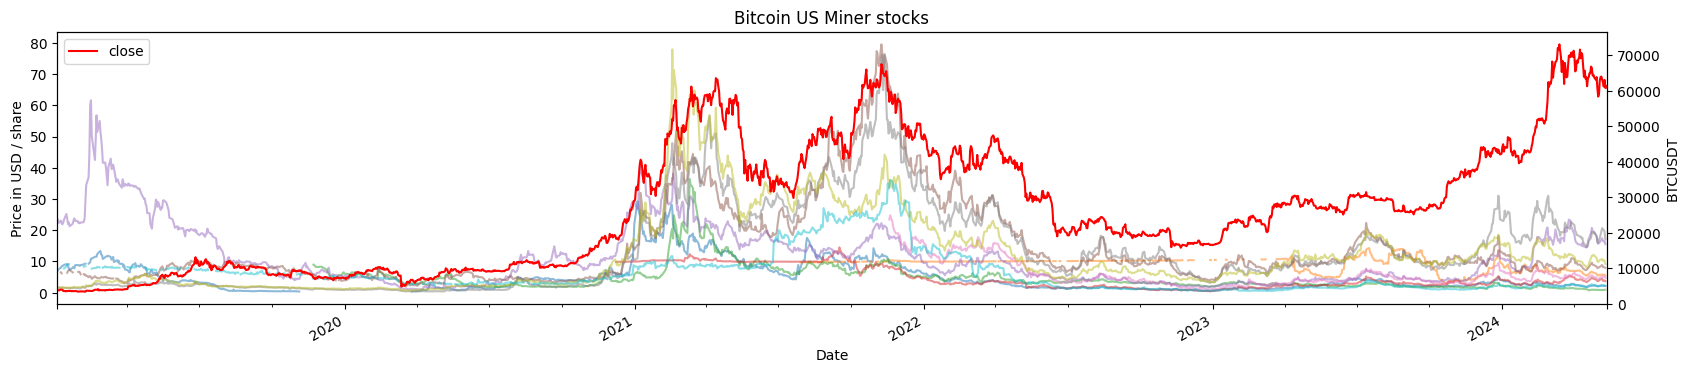

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

# Plot the data from df_tickers on the primary y-axis
close_cols = [col for col in df_tickers.columns if "close" in col]

df_tickers.plot(y=close_cols, title="Bitcoin US Miner stocks", alpha=0.5, ax=ax1, legend=False)
ax1.set_ylabel("Price in USD / share")

# Plot the data from df_btc on the secondary y-axis
df_btc.plot(
    x="open_time", y="close", ax=ax2, color="r"
)

ax2.set_ylabel("BTCUSDT")

plt.show()

<h4>Company overview</h4>

10 considered companies are engaged in Bitcoin mining. All companies are US-based. Below is a description of those 3 companies whose stocks are most correlated with Bitcoin.

<ul>
    <li>Marathon Digital Holdings (MARA)</li>
    <li>Riot Platforms (RIOT)</li>
    <li>Hut 8 Corp. (HUT)</li>
</ul>


<h4>Marathon Digital Holdings (MARA)</h4>

Market Cap: $4.68 billion
Stock Price: $17.16
Founded: 2010
Headquarters: Fort Lauderdale, Florida, USA

Description: Marathon Digital Holdings operates as a digital asset technology company focused on the Bitcoin ecosystem.
Business Focus:
Marathon is among the largest and most energy-efficient Bitcoin mining companies in North America and holds a significant amount of Bitcoin.
Originally known as Marathon Patent Group, Inc., the company rebranded to Marathon Digital Holdings, Inc. in February 2021.

Operations:
Focuses on mining digital assets, primarily Bitcoin, leveraging advanced technology to maintain efficiency and competitiveness.

</br>

<h4>Riot Platforms, Inc. (RIOT)</h4>

Market Cap: $2.65 billion
Stock Price: $9.30
Founded: 2000
Headquarters: Castle Rock, Colorado, United States
Description: Riot Platforms is a rapidly expanding large-scale Bitcoin mining operation in the United States.

Business Focus:
Riot Platforms is committed to supporting the Bitcoin blockchain through its extensive mining activities.
Aims to increase its Bitcoin mining hash rate and infrastructure capacity significantly.
Operations:

Focuses on enhancing and expanding its operations to maintain its role as a key player in the Bitcoin mining industry.

</br>

<h4>Hut 8 Corp. (HUT)</h4>

Market Cap: $0.71 billion
Stock Price: $7.97
Founded: 2017
Headquarters: Miami, Florida, USA

Description: Hut 8 Corp. engages in high performance computing (HPC) infrastructure, technology solutions, and digital asset mining.

Business Focus:
Hut 8 drives innovation in the digital economy through its focus on HPC and cutting-edge technology solutions in addition to Bitcoin mining.
Operates in four segments: Digital Assets Mining, Managed Services, High Performance Computing – Colocation and Cloud, and Other.

Operations:
Hut 8 acquires, builds, manages, and operates data centres for mining, computing, and AI applications, highlighting its diversified approach to leveraging digital assets.

<h4>Find portfolio weights tracking Bitcoin the best and backtest this tracking on the holdout dataset</h4>

In [12]:
df_btc.index = df_btc["open_time"]
df_close: pd.DataFrame = df_tickers[close_cols].copy() # only leave close columns

df_close = pd.concat([df_close, df_btc["close"]], axis=1)
df_close.columns = df_close.columns[:-1].tolist() + ["BTC_close"]

df_close.head(2)

,BTBT_close,BTDR_close,CAN_close,CIFR_close,CLSK_close,HUT_close,IREN_close,MARA_close,RIOT_close,WULF_close,BTC_close
2019-01-02,6.79,NaN,NaN,NaN,22.8,NaN,NaN,1.52,1.71,8.68,3858.56
2019-01-03,7.00,NaN,NaN,NaN,23.5,6.469,NaN,1.52,1.54,NaN,3766.78


In [13]:
# calculate returns
df_returns = df_close.pct_change(fill_method=None)
df_returns.columns = [f"{ticker}_return" for ticker in tickers + ["BTC"]]
df_returns.head(5)

,MARA_return,CLSK_return,RIOT_return,CIFR_return,HUT_return,IREN_return,WULF_return,BTDR_return,CAN_return,BTBT_return,BTC_return
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.030928,NaN,NaN,NaN,0.030702,NaN,NaN,0.000000,-0.099415,NaN,-0.023786
2019-01-04,0.071429,NaN,NaN,NaN,-0.051064,NaN,NaN,0.059211,0.071429,NaN,0.006698
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005551
2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057450


Label holidays and weekends (non-traded days) to calculate BTC return not daily but over the holiday period time

In [14]:
import holidays

hol = holidays.financial_holidays("NYSE")
df_close["date"] = df_close.index

df_close["is_workday"] = df_close["date"].apply(hol.is_workday) 

df_close.tail(1)

,BTBT_close,BTDR_close,CAN_close,CIFR_close,CLSK_close,HUT_close,IREN_close,MARA_close,RIOT_close,WULF_close,BTC_close,date,is_workday
2024-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61319.99,2024-05-12,False


In [15]:
btc_returns: List[float] = []
prev_close = np.nan

for i, row in df_close.iterrows():
    if row["is_workday"]:
        pct_change = (row["BTC_close"] - prev_close) / prev_close
        btc_returns.append(pct_change)
        prev_close = row["BTC_close"]

df_close = df_close[df_close["is_workday"]].copy()
df_close["BTC_return_adj"] = btc_returns

In [16]:
df_close.tail(1)

,BTBT_close,BTDR_close,CAN_close,CIFR_close,CLSK_close,HUT_close,IREN_close,MARA_close,RIOT_close,WULF_close,BTC_close,date,is_workday,BTC_return_adj
2024-05-10,2.15,5.5,0.959,3.72,15.57,7.99,4.79,17.16,9.2,2.23,60799.99,2024-05-10,True,-0.036053


In [17]:
df_returns = pd.DataFrame()

for ticker in tickers:
    df_returns[f"{ticker}_return"] = df_close[f"{ticker}_close"].pct_change(fill_method=None)

df_returns["BTC_return_adj"] = df_close["BTC_return_adj"]
df_returns.tail(2)

,MARA_return,CLSK_return,RIOT_return,CIFR_return,HUT_return,IREN_return,WULF_return,BTDR_return,CAN_return,BTBT_return,BTC_return_adj
2024-05-09,-0.021901,0.013439,-0.006763,0.046358,-0.004884,-0.003899,0.012876,0.024779,0.051136,0.009217,0.030738
2024-05-10,-0.126718,-0.061483,-0.105058,-0.058228,-0.019632,-0.062622,-0.055085,-0.050086,0.036757,-0.018265,-0.036053


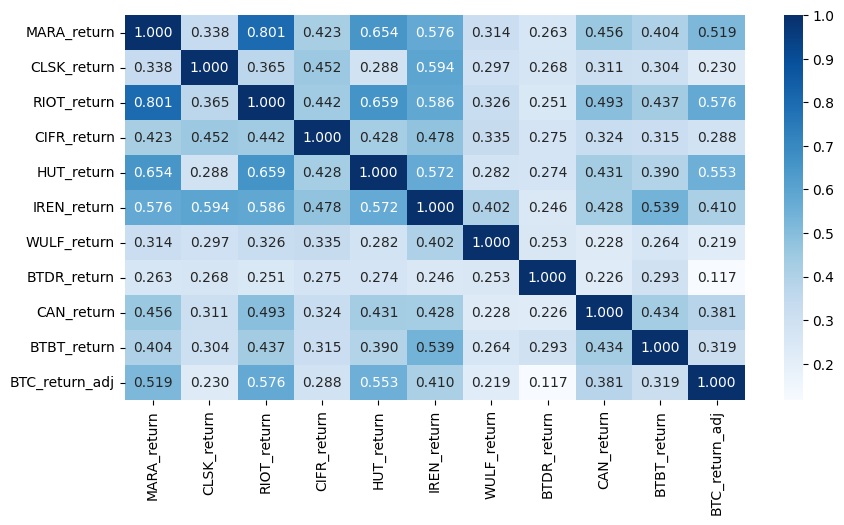

In [18]:
plt.figure(figsize=(10, 5))

sns.heatmap(df_returns.corr(), cmap=plt.cm.Blues, annot=True, fmt=".3f")
plt.show()

In [19]:
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from functools import partial


def minimize_mape_loss(W: np.array, reg_cols: List[str], train: pd.DataFrame) -> float:
    replicated_returns: np.array = train[reg_cols] @ W.T
    return mean_absolute_error(
        y_true=train["BTC_return_adj"], y_pred=replicated_returns
    )

def replicating_portfolio_constr(W: np.array):
    return W.sum() - 1


def replicate_train(df_train: pd.DataFrame, reg_cols: List[str]) -> np.array:
    """Find weigths that replicate portfolio the best"""
    constrs = [{"type": "eq", "fun": replicating_portfolio_constr}]
    x0 = [0.1] * len(reg_cols)

    sol = minimize(
        fun=partial(minimize_mape_loss, train=df_train, reg_cols=reg_cols),
        x0=x0,
        constraints=constrs,
    )
    return sol.x

def replicate_test(W: np.array, df_test: pd.DataFrame, reg_cols: List[str]) -> Tuple[float, list, list]:
    replicated_returns: np.array = df_test[reg_cols].values @ W.T
    mape: float = mean_absolute_percentage_error(
        y_pred=replicated_returns, y_true=df_test["BTC_return_adj"]
    )
    return (
        mape, list(replicated_returns), df_test["BTC_return_adj"].values.tolist()
    )

<h4>Create weekly candles</h4>

In [20]:
basket_tickers = ['MARA', 'CLSK', 'RIOT', 'CIFR', 'HUT', 'IREN', 'WULF', 'BTDR', 'CAN', 'BTBT']
reg_cols: List[str] = [f"{ticker}_return" for ticker in basket_tickers]

df_returns = df_returns[reg_cols + ["BTC_return_adj"]].copy()
df_returns.head(5)

,MARA_return,CLSK_return,RIOT_return,CIFR_return,HUT_return,IREN_return,WULF_return,BTDR_return,CAN_return,BTBT_return,BTC_return_adj
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.000000,0.030702,-0.099415,NaN,NaN,NaN,NaN,NaN,NaN,0.030928,-0.023786
2019-01-04,0.059211,-0.051064,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,0.071429,0.006698
2019-01-07,0.037267,0.035874,-0.012121,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,0.048375
2019-01-08,0.017964,-0.038961,0.042945,NaN,-0.046154,NaN,NaN,NaN,NaN,0.057500,-0.005111


In [21]:
df_returns = df_returns.fillna(0) + 1
df_returns.head(1)

,MARA_return,CLSK_return,RIOT_return,CIFR_return,HUT_return,IREN_return,WULF_return,BTDR_return,CAN_return,BTBT_return,BTC_return_adj
2019-01-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
df_weekly_returns = df_returns + 1
df_weekly_returns = df_weekly_returns.resample(rule="1W").prod()
df_weekly_returns.head(2)

,MARA_return,CLSK_return,RIOT_return,CIFR_return,HUT_return,IREN_return,WULF_return,BTDR_return,CAN_return,BTBT_return,BTC_return_adj
2019-01-06,8.236842,7.915416,7.873851,8.0,8.000000,8.0,8.0,8.0,8.0,8.413844,7.931329
2019-01-13,31.517313,32.801360,31.730773,32.0,31.261538,32.0,32.0,32.0,32.0,34.856082,31.233609


In [23]:
train_days = 21
test_days = 4

window_range = range(0, df_returns.shape[0] - train_days - test_days, test_days)

metrics: List[float] = []
y_pred, y_real = [], []
dates: List[pd.Timestamp] = []

for i in tqdm(window_range):
    
    df_train, df_test = (
        df_returns.iloc[i : i + train_days],
        df_returns.iloc[i + train_days: i + train_days + test_days],
    )

    W_replicating: np.array = replicate_train(df_train=df_train, reg_cols=reg_cols)
    mape, replicated, real = replicate_test(W=W_replicating, df_test=df_test, reg_cols=reg_cols)
    
    metrics.append(mape)
    y_pred.extend(replicated)
    y_real.extend(real)
    
    dates.extend([df_test.index[0] + timedelta(days=i) for i in range(4)])

100%|██████████| 331/331 [02:03<00:00,  2.68it/s]


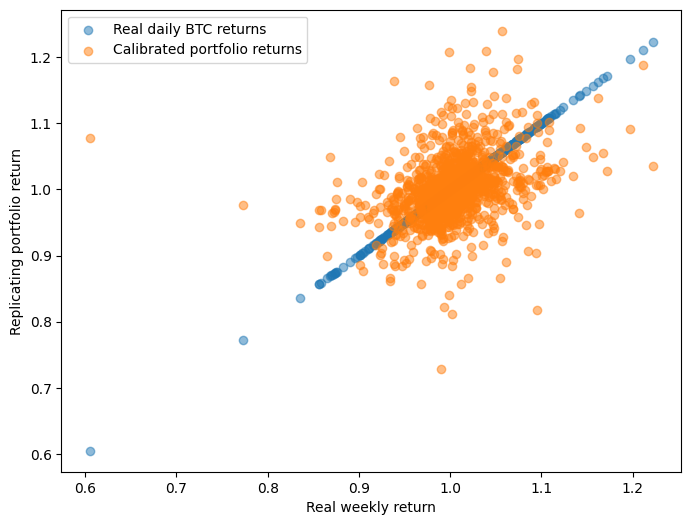

In [24]:
plt.figure(figsize=(8, 6))

plt.scatter(y_real, y_real, alpha=.5, label="Real daily BTC returns")
plt.scatter(y_real, y_pred, alpha=.5, label="Calibrated portfolio returns")

plt.xlabel("Real weekly return")
plt.ylabel("Replicating portfolio return")

plt.legend()
plt.show()

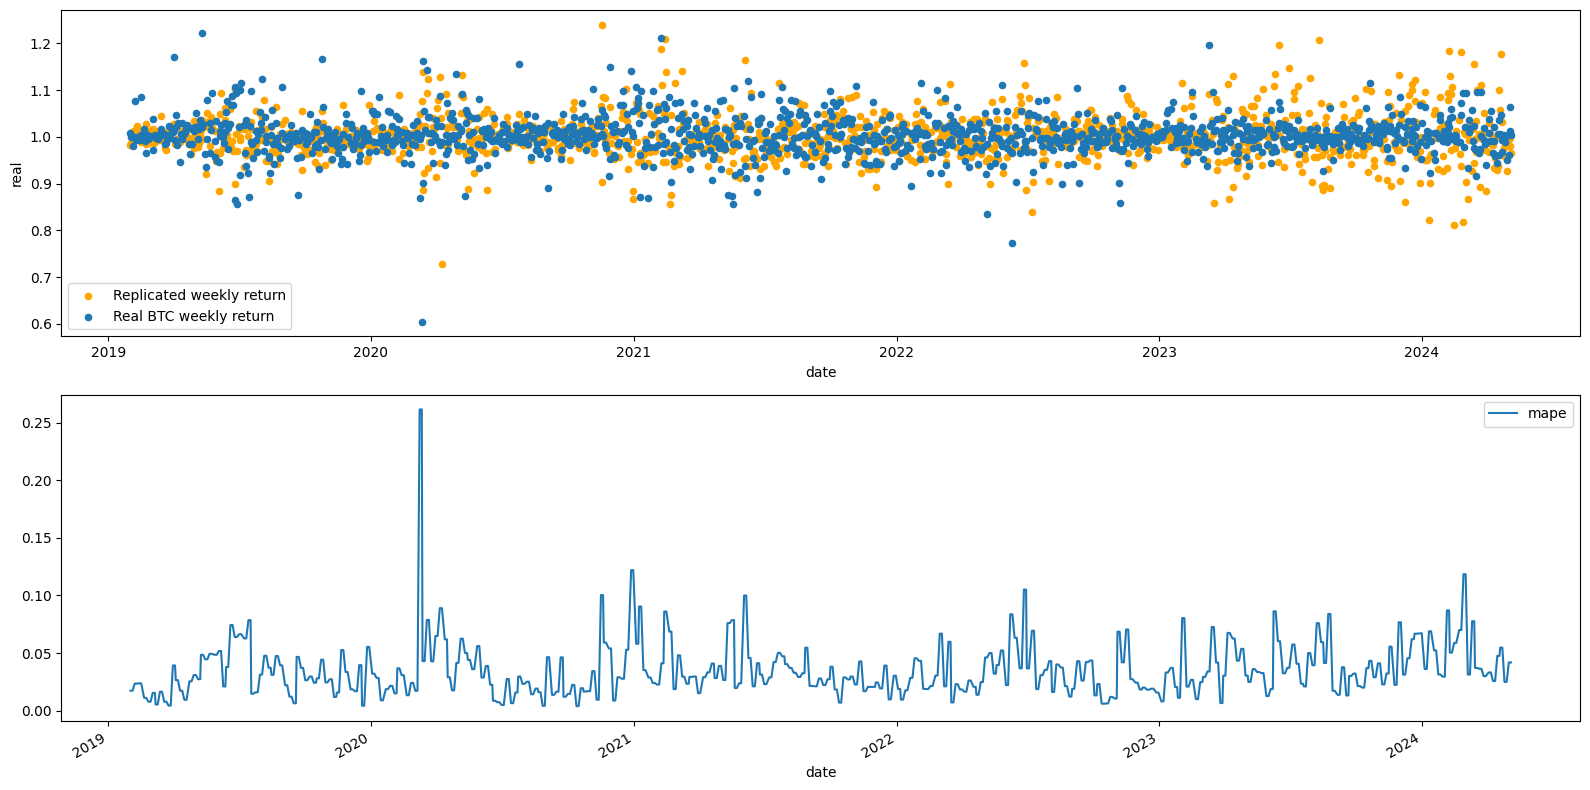

In [25]:
mapes = []

for el in metrics:
    mapes.extend([el]*4)

df_rep = pd.DataFrame({
    "replicated": y_pred,
    "real": y_real,
    "date": dates,
    "mape": mapes
})

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

df_rep.plot.scatter(x="date", y="replicated", ax=ax1, color="orange", label="Replicated weekly return")
df_rep.plot.scatter(x="date", y="real", ax=ax1, label="Real BTC weekly return")
df_rep.plot(x="date", y="mape", ax=ax2)

plt.legend()
plt.tight_layout()
plt.show()

<h4>Simulate basket future prices</h4>

We will use GBM where random increments are correlated with each other, to achieve this we will apply Cholesky decomposition

In [26]:
basket_returns: List[str] = [f"{ticker}_return" for ticker in basket_tickers]
basket_close: List[str] = [f"{ticker}_close" for ticker in basket_tickers]

X_corr = df_returns[basket_returns].corr().values

In [27]:
mus = df_returns[basket_returns].mean().values
cov = df_returns[basket_returns].cov().values
stddevs = df_returns[basket_returns].std().values

In [28]:
stddevs, mus

(array([0.08853429, 0.08321487, 0.07340816, 0.05845241, 0.07717481,
        0.05464789, 0.07149782, 0.04129546, 0.07491163, 0.09372615]),
 array([1.00542888, 1.00282763, 1.00384318, 1.00095225, 1.00285608,
        1.00024253, 1.00203975, 1.00038113, 1.0009567 , 1.00315746]))

Since we want to simulate correlated paths using Cholesky decomposition

In [29]:
S_zeros = df_close[basket_close].iloc[-1].values
S_zeros

array([17.16 , 15.57 ,  9.2  ,  3.72 ,  7.99 ,  4.79 ,  2.23 ,  5.5  ,
        0.959,  2.15 ])

In [30]:
def generate_paths(S_zeros: np.array) -> np.array:
    num_steps = 24 * 4
    num_series = 10

    dt = 1 / (252 * 24)

    # Generate correlated normal random variables
    W = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_series, num_steps))
    W_corr = (np.linalg.cholesky(X_corr) @ W).T

    # Initialize arrays for storing the GBM values
    St = np.zeros(shape=(num_steps, num_series))
    St[0, :] = S_zeros

    r = 0.05

    for j in range(num_series):
        for i in range(1, num_steps):
            St[i, j] = St[i-1, j] * np.exp(
                (r - 1/2*stddevs[j]**2)*dt + stddevs[j] * W_corr[i, j]
            )

    return St.reshape(1, num_steps, num_series)


def get_multiple_paths(S_zeros) -> np.array:
    ST = None

    for i in range(250):
        St = generate_paths(S_zeros=S_zeros)
        if i == 0:
            ST = St
        else:
            ST = np.concatenate([ST, St], axis=0)
    
    return ST

ST = get_multiple_paths(S_zeros=S_zeros)

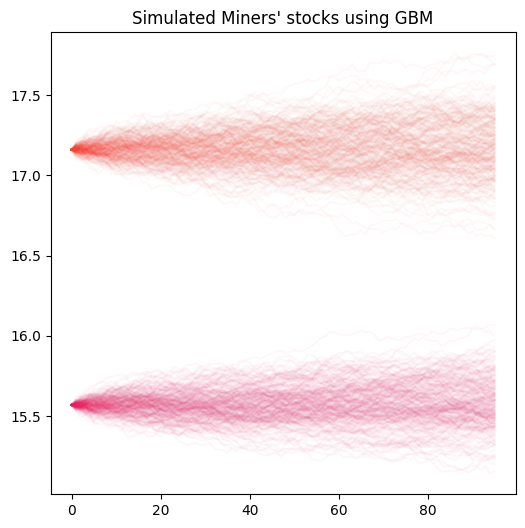

In [31]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

colors = [
    "#F44336",  # Red 500
    "#E91E63",  # Pink 500
    "#9C27B0",  # Purple 500
    "#673AB7",  # Deep Purple 500
    "#3F51B5",  # Indigo 500
    "#2196F3",  # Blue 500
    "#03A9F4",  # Light Blue 500
    "#00BCD4",  # Cyan 500
    "#009688",  # Teal 500
    "#4CAF50"   # Green 500
]

for i, color in enumerate(colors[:2]):
    ax.plot(ST[:250, :, i].T, alpha=.03, color=color)
    # ax.set_yscale('log')


plt.title("Simulated Miners' stocks using GBM")
plt.show()

<h4>Find optimal weights for the next 3 weeks</h4>

In [32]:
df_train = df_returns.iloc[-21:].copy() # get the last 21 trading days
# Find optimal weights
weights = replicate_train(df_train=df_train, reg_cols=reg_cols)
weights

array([-0.21328726,  0.47799175, -0.35579667, -0.48246375, -0.01120028,
        0.0572525 ,  0.14257712,  0.76138218,  0.09245742,  0.531087  ])

In [33]:
pd.DataFrame({
    "ticker": basket_tickers,
    "weights": weights,
})

,ticker,weights
0,MARA,-0.213287
1,CLSK,0.477992
2,RIOT,-0.355797
3,CIFR,-0.482464
4,HUT,-0.011200
5,IREN,0.057252
6,WULF,0.142577
7,BTDR,0.761382
8,CAN,0.092457
9,BTBT,0.531087


In [34]:
basket_tickers

['MARA', 'CLSK', 'RIOT', 'CIFR', 'HUT', 'IREN', 'WULF', 'BTDR', 'CAN', 'BTBT']

In [35]:
# train tracking loss
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# roughly speaking on average we are wrong by 1.6% during these 21 days
MAPE(y_pred=df_train[reg_cols] @ weights.T, y_true=df_train["BTC_return_adj"])

0.01688811414320072

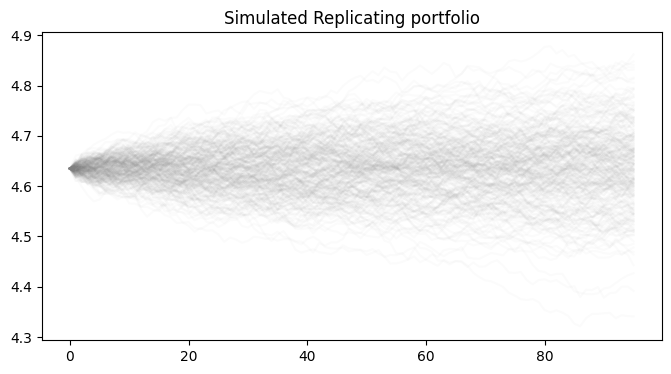

In [36]:
# create simulation of the portfolio with weights above
St_portfolio: np.array = np.sum(ST * weights, axis=2)

plt.figure(figsize=(8, 4))
plt.title("Simulated Replicating portfolio")
plt.plot(St_portfolio.T, color="grey", alpha=.03)

plt.show()

In [37]:
# distribution of returns at 21st day
K = 4.65
r = 0.05

payoffs = np.maximum(St_portfolio[:, -1] - K, 0)
premium = np.mean(payoffs * np.exp(-r*5/365))

premium

0.02868437147473468

In [38]:
premium / K

0.00616868203757735

In our context, since we are replicating returns of BTC, buying ATM portfolio option is the same as buying ATM BTC call option if replicating is robust enough, also diversification of the portfolio allows to lessen idiosyncratic risks of each mining company.


$$\text{Synthetic ATM BTC Call payoff} = \max(\sum_{i=1}^N{(S_{iT} - S_{i0}) w_i}, 0) \cdot \Psi = \max(S_{\text{portfolio}, T} - S_{\text{portfolio}, 0}) \cdot \Psi$$

Where $\Psi$ is an adjustment factor that changes payoff based on how far off the return of replicating portfolio is from BTC spot price at time of maturity

<h4>Maybe add some adjustment to price given that we could run into replication error</h4>

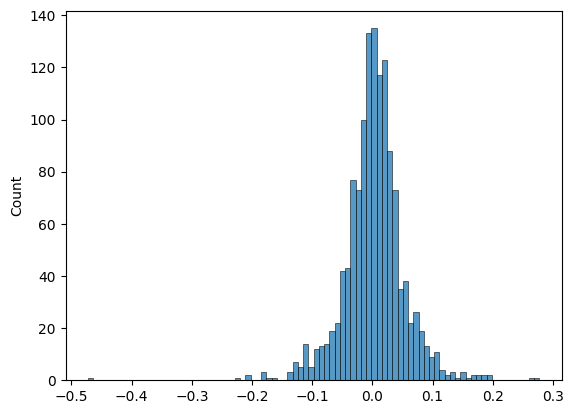

In [39]:
# we have a history of misreplication 

btc_returns = np.array(y_real) - 1
replicating_returns = np.array(y_pred) - 1

replicating_error = (btc_returns - replicating_returns)

sns.histplot(replicating_error)
plt.show()

<h4>Greeks of the option</h4> 

Weighted $\Delta = \sum_{i=1}^N{w_i \cdot \frac{\partial{C}}{\partial{S_{0,i}}}}$

In [40]:
def calculate_premium(St: np.array, W: np.array, K: float = 4.65) -> float:
    St_portfolio: np.array = np.sum(St * W, axis=2)
    payoffs = np.maximum(St_portfolio[:, -1] - K, 0)
    premium = np.mean(payoffs * np.exp(-r*4/365))
    return premium


def calculate_call_price() -> Tuple[float, np.array]:
    S0_changed = np.random.uniform(0.8, 1.2, size=10) * S_zeros
    paths = get_multiple_paths(S_zeros=S0_changed)
    premium = calculate_premium(St=paths, W=weights, K=5)
    return (
        premium, S0_changed
    )

In [41]:
S0_values, premiums = [], []

for i in tqdm(range(1000)):
    S0_changed = np.random.uniform(0.8, 1.2, size=10) * S_zeros
    paths = get_multiple_paths(S_zeros=S0_changed)
    premium = calculate_premium(St=paths, W=weights, K=5)

    S0_values.append(S0_changed)
    premiums.append(premium)

100%|██████████| 1000/1000 [13:12<00:00,  1.26it/s]


In [42]:
modified_s0 = np.vstack(S0_values)

In [43]:
df_modified_s0 = pd.DataFrame(data=modified_s0)
df_modified_s0["premium"] = premiums

N = df_modified_s0.shape[0]

dx = np.zeros(shape=(N, N))
dy = np.zeros(shape=(N, N))

moneyness = np.zeros(shape=(N, N))

for i in tqdm(range(N)):
    for j in range(1, N):
        S0_cur = df_modified_s0.iloc[i, :-1].dot(weights)
        S0_other = df_modified_s0.iloc[j, :-1].dot(weights)

        moneyness[i, j] = S0_cur / 5
        
        dx[i, j] = np.sum(S0_other - S0_cur)
        dy[i, j] = df_modified_s0.iloc[j, -1] - df_modified_s0.iloc[i, -1]

100%|██████████| 1000/1000 [02:38<00:00,  6.30it/s]


In [44]:
deltas = dy / dx

deltas = deltas.flatten()
moneyness = moneyness.flatten()

C:\Users\mihai\AppData\Local\Temp\ipykernel_3664\3728106692.py:1: RuntimeWarning: invalid value encountered in divide
  deltas = dy / dx


In [45]:
bins = np.arange(0, moneyness.max(), 0.01)

df_delta = pd.DataFrame({
    "S/K": moneyness,
    "delta": deltas
})

df_delta["group"] = pd.cut(df_delta["S/K"], bins=bins)

avg_delta = df_delta.groupby("group")["delta"].mean().values

C:\Users\mihai\AppData\Local\Temp\ipykernel_3664\1108399984.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delta = df_delta.groupby("group")["delta"].mean().values


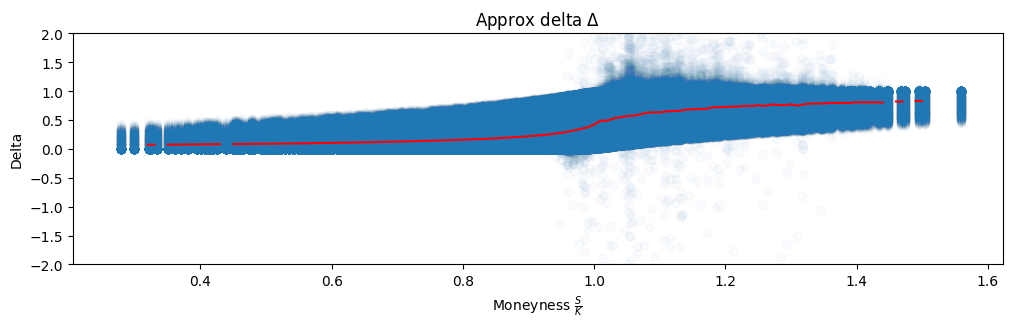

In [46]:
plt.figure(figsize=(12, 3))
plt.scatter(moneyness, deltas, alpha=.01)

plt.title("Approx delta $\Delta$")
plt.plot(bins[:-1], avg_delta, color="red")

plt.ylim([-2, 2])
plt.xlabel(r"Moneyness $\frac{S}{K}$")
plt.ylabel("Delta")

plt.show()